In [2]:
# install.packages("jsonlite")
# install.packages("lm.beta")
# install.packages("anomalize")

library(jsonlite)
library(lm.beta)
library(anomalize)
library(tibbletime)
library(dplyr)
library(ggplot2)
library(gridExtra)

# setwd("C:/Users/tpdud/Desktop/다음 소프트/Auto Matching_Clustering")

In [3]:
whole = readLines("Data.jsonl",encoding="UTF-8")

json_df = data.frame()
for(i in 1:length(whole)) {
    temp = data.frame(keyword=jsonlite::fromJSON(txt=whole[i])$keyword, data=t(jsonlite::fromJSON(txt=whole[i])$data[1]))
    json_df = rbind(json_df, temp)
}
json_df = json_df[-which(apply(data.frame(json_df$data), 2, sum)==0),]  ## 전부 다 0인 데이터셋 pass

Converting from tbl_df to tbl_time.
Auto-index message: index = time
frequency = 7 days
trend = 18 days


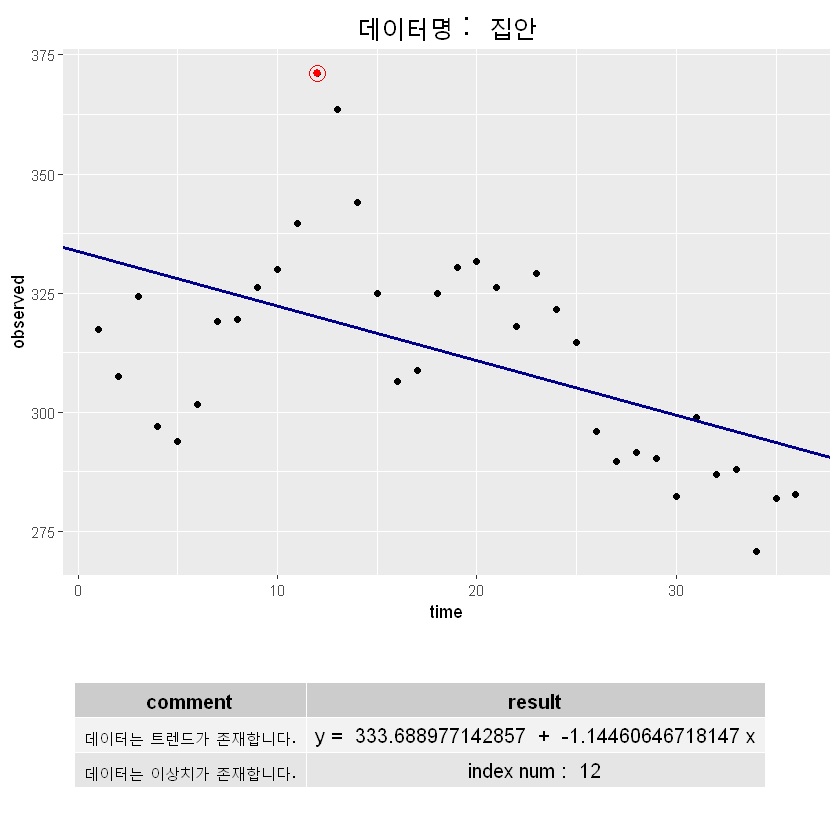

In [5]:
k = 1 ## dataset 하나 지정
data_title = json_df[k,1]
dataset = na.omit(json_df[k,2][[1]])

# linear regression
temp = data.frame(x = 1:length(dataset), y = dataset)
model = lm(temp[,2] ~ temp[,1], data=temp)  ## model : 선형회귀모형
isRegression = ifelse(summary(lm.beta(model))$coef[2,5] < 0.05, TRUE, FALSE)  ## 회귀계수 유의한지
b = summary(lm.beta(model))$coef[2,1]  ## slope
a = summary(lm.beta(model))$coef[1,1]  ## intercept


# anomaly : 이상치 탐지
anomalized = as_data_frame(data.frame(time=as.Date(1:length(dataset),origin = "2020-01-01"),value=dataset)) %>%
    time_decompose(value) %>%  ## season, trend, extra 분해
    anomalize(remainder, alpha=0.05, max_anoms=0.05)   ## 이상 감지 수행(하한, 상한)
isAnomaly = ifelse(sum(anomalized$anomaly=="Yes") > 0, TRUE, FALSE)  ## 이상치 존재하는지


# plot
df = data.frame(x=1:length(dataset), y=dataset)
result = ggplot(df, aes(x=df[,1], y=df[,2])) + geom_point() + xlab('time') + ylab('observed') +
ggtitle(paste("데이터명 : ",data_title)) + theme(plot.title = element_text(size = 20, hjust = 0.5))
if(isRegression) {
    result = result + geom_abline(aes(intercept=a, slope=b), color='darkblue', size = 1)
}
if(isAnomaly) {
   result = result + geom_point(mapping=aes(x=df[which(anomalized$anomaly=="Yes"),1],y=df[which(anomalized$anomaly=="Yes"),2]), color="red", size=2) +
    geom_point(mapping=aes(x=df[which(anomalized$anomaly=="Yes"),1],y=df[which(anomalized$anomaly=="Yes"),2]), shape=1, color="red", size=4.5)
}


if(isRegression) {
    comment_regression = data.frame(comment="데이터는 트렌드가 존재합니다.", result=paste("y = ", a, " + ", b, "x"))
} else comment_regression = data.frame(comment="데이터는 트렌드가 존재하지 않습니다.", result="-")

if(isAnomaly) {
    comment_anomaly = data.frame(comment="데이터는 이상치가 존재합니다.", result=paste("index num : ", which(anomalized$anomaly=="Yes")))
} else comment_anomaly = data.frame(comment="데이터는 이상치가 존재하지 않습니다.", result="-")
comment = rbind(comment_regression, comment_anomaly)


grid.arrange(result, tableGrob(comment, rows=NULL), heights = c(3, 1))


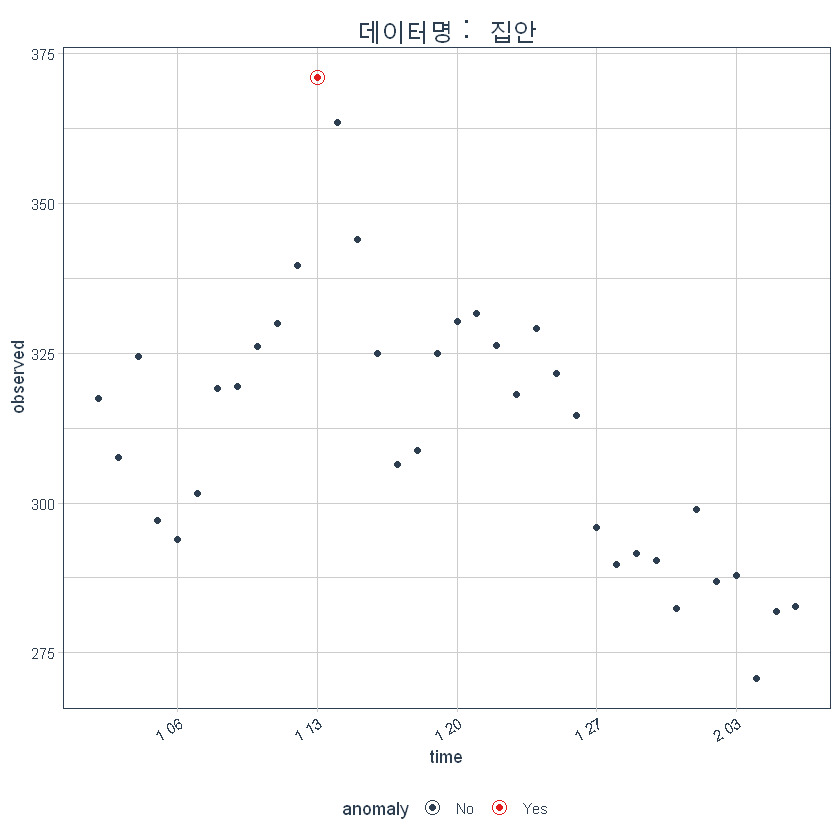

In [225]:
# plot(1) - abline 출력 안됨
anomalized %>% plot_anomalies() + geom_abline(aes(intercept=a, slope=b), color='blue', size = 1.5) +
ggtitle(paste("데이터명 : ",data_title)) + theme(plot.title = element_text(size = 20, hjust = 0.5))